In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 3)  # (width, height) in inches
from mzsql import *
import timeit

## Create DuckDB for querying

Initially ignore indexing/organizing and just write the scans in as they are in the MS file

In [2]:
import datetime
turn_mzml_duckdb("../demo_data/180205_Poo_TruePoo_Full1.mzML", 
                 "../demo_data/180205_Poo_TruePoo_Full1.duckdb")

'../demo_data/180205_Poo_TruePoo_Full1.duckdb'

## Query the database

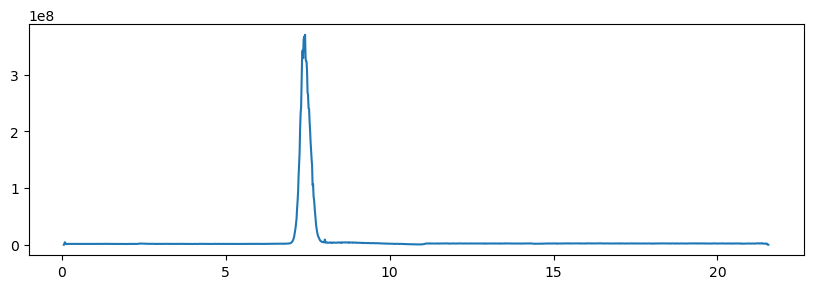

In [3]:
chrom_data = get_chrom_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 118.0865, 10)
plt.plot(chrom_data["rt"], chrom_data["int"])

<StemContainer object of 3 artists>

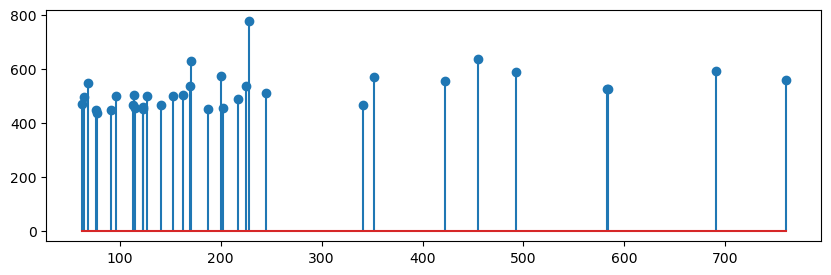

In [4]:
spec_data = get_spec_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 1)
plt.stem(spec_data["mz"], spec_data["int"])

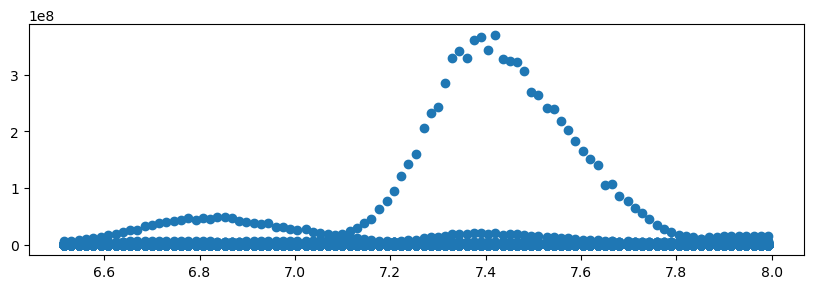

In [5]:
rtrange_data = get_rtrange_duckdb('../demo_data/180205_Poo_TruePoo_Full1.duckdb', 6.5, 8)
plt.scatter(rtrange_data["rt"], rtrange_data["int"])

We also might be able to make some improvements for chromatogram extraction by ordering by RT before writing it out to make use of DuckDB's row groups functionality.

In [6]:
turn_mzml_duckdb("../demo_data/180205_Poo_TruePoo_Full1.mzML", 
                 "../demo_data/180205_Poo_TruePoo_Full1_ord.duckdb", 
                 ordered=True)

'../demo_data/180205_Poo_TruePoo_Full1_ord.duckdb'

## Timing comparison

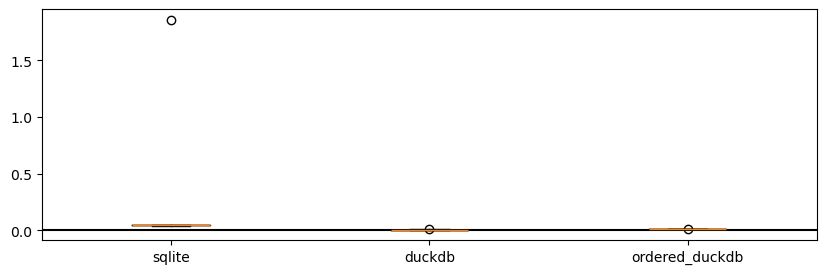

In [7]:
sqlite_spec = timeit.repeat('get_spec_sqlite("../demo_data/180205_Poo_TruePoo_Full1.sqlite", 1)', globals=globals(), number=1, repeat=10)
duckdb_spec = timeit.repeat('get_spec_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 1)', globals=globals(), number=1, repeat=10)
ord_duckdb_spec = timeit.repeat('get_spec_duckdb("../demo_data/180205_Poo_TruePoo_Full1_ord.duckdb", 1)', globals=globals(), number=1, repeat=10)
plt.boxplot([sqlite_spec, duckdb_spec, ord_duckdb_spec], tick_labels=["sqlite", "duckdb", "ordered_duckdb"])
plt.axhline(y=0, color="k")
plt.show()

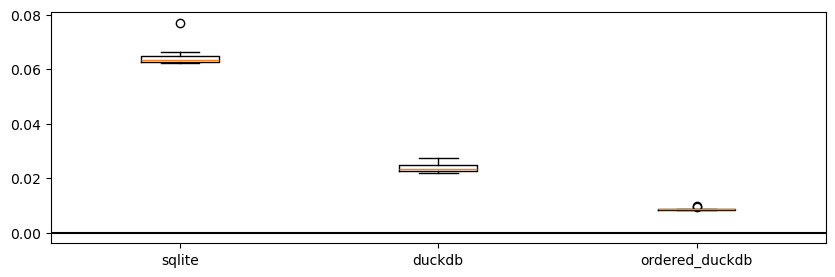

In [8]:
sqlite_chrom = timeit.repeat('get_chrom_sqlite("../demo_data/180205_Poo_TruePoo_Full1.sqlite", 118.0865, 10)', globals=globals(), number=1, repeat=10)
duckdb_chrom = timeit.repeat('get_chrom_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 118.0865, 10)', globals=globals(), number=1, repeat=10)
ord_duckdb_chrom = timeit.repeat('get_chrom_duckdb("../demo_data/180205_Poo_TruePoo_Full1_ord.duckdb", 118.0865, 10)', globals=globals(), number=1, repeat=10)
plt.boxplot([sqlite_chrom, duckdb_chrom, ord_duckdb_chrom], tick_labels=["sqlite", "duckdb", "ordered_duckdb"])
plt.axhline(y=0, color="k")
plt.show()

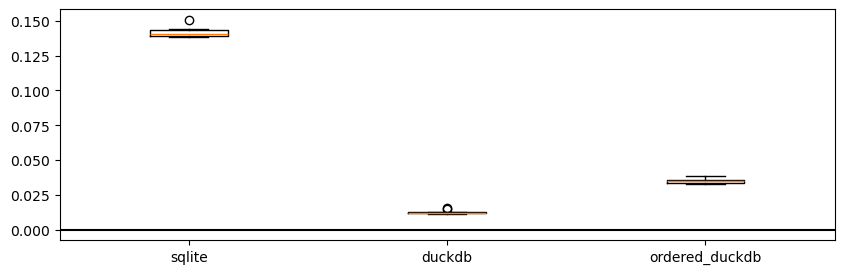

In [9]:
sqlite_rtrange = timeit.repeat('get_rtrange_sqlite("../demo_data/180205_Poo_TruePoo_Full1.sqlite", 6.5, 8)', globals=globals(), number=1, repeat=10)
duckdb_rtrange = timeit.repeat('get_rtrange_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 6.5, 8)', globals=globals(), number=1, repeat=10)
ord_duckdb_rtrange = timeit.repeat('get_rtrange_duckdb("../demo_data/180205_Poo_TruePoo_Full1_ord.duckdb", 6.5, 8)', globals=globals(), number=1, repeat=10)
plt.boxplot([sqlite_rtrange, duckdb_rtrange, ord_duckdb_rtrange], tick_labels=["sqlite", "duckdb", "ordered_duckdb"])
plt.axhline(y=0, color="k")
plt.show()

In [12]:
import pandas as pd
rtrange_df = pd.DataFrame({
    "method": ["sqlite"]*10 + ["duckdb"]*10 + ["ordered_duckdb"]*10, 
    "time": sqlite_rtrange + duckdb_rtrange + ord_duckdb_rtrange
})
rtrange_df["metric"] = "rtrange"
spec_df = pd.DataFrame({
    "method": ["sqlite"]*10 + ["duckdb"]*10 + ["ordered_duckdb"]*10,
    "time": sqlite_spec + duckdb_spec + ord_duckdb_spec
})
spec_df["metric"] = "spec"
chrom_df = pd.DataFrame({
    "method": ["sqlite"]*10 + ["duckdb"]*10 + ["ordered_duckdb"]*10,
    "time": sqlite_chrom + duckdb_chrom + ord_duckdb_chrom
})
chrom_df["metric"] = "chrom"

complete_timings = pd.concat([spec_df, chrom_df, rtrange_df], ignore_index=True)
complete_timings["datetime"] = pd.to_datetime('now')
complete_timings.to_csv("compiled_timings.csv", mode='a', index=False, header=False)